# modelの作成

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Dense
from keras .layers import Dropout
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import Conv2D
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# シード値の設定
再現性の確保するためにシード値を設定する。

In [2]:
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

## 画像の作成
### モデルの訓練データと評価データの作成  
回転などの水増しは特にしない。

In [3]:
# 画像サイズ
im_rows = 64
im_cols = 64
im_color = 3
out_size = 2

In [4]:
datagene = ImageDataGenerator(rescale = 1./255, validation_split = 0.3)

# バッチサイズ（学習するデータの枚数）
batch_size = 1000

# 訓練データの作成
filepath = "static/base_images"
train_generator = datagene.flow_from_directory(
    directory = filepath
    , target_size = (im_rows, im_cols)
    , class_mode = "categorical"
    , shuffle = True
    , batch_size = batch_size
    , subset = "training"
)

# 検証データの作成
val_generator = datagene.flow_from_directory(
    directory = filepath
    , target_size = (im_rows, im_cols)
    , class_mode = "categorical"
    , batch_size = batch_size
    , subset = "validation"
)

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


In [5]:
# クラスの確認
print(f"訓練用:{train_generator.class_indices}")
print(f"検証用:{val_generator.class_indices}")

訓練用:{'cat': 0, 'dog': 1}
検証用:{'cat': 0, 'dog': 1}


## ResNet50を用いたモデル作成
転移学習を用いてモデルを作成する。

In [6]:
from keras.applications.resnet import ResNet50
from keras.layers import Input
input_tensor = Input(shape=(im_rows, im_cols, im_color))
base_model = ResNet50(include_top = False # 全結合層を除くことができる
                    , weights = "imagenet" # 学習済みモデルの重みを使用できる
                    , input_tensor = input_tensor)
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [7]:
# すべての重みを固定する
for layer in base_model.layers[0::]:
    layer.trainable = False

# 確認
for layer in base_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000013316337BE0> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x0000013316337280> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001335E86FDC0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001335ECC4BE0> False
<keras.layers.core.activation.Activation object at 0x000001335ECC5AB0> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000001335ECC63B0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001335ECC76A0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001335ECC6AD0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001335ECC74F0> False
<keras.layers.core.activation.Activation object at 0x000001335ECC6F50> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001335ED4E740> False
<keras.layers.normalization.batch_normalization.BatchNormalization obj

Trainable paramsは訓練されるパラメータのこと。  
これがDense層のparamsと一致していることを確認する。

In [8]:
# ResNet50のモデルに全結合分類を追加し、学習するモデルを作成する。
my_model = Sequential()

my_model.add(base_model)
my_model.add(Flatten())
my_model.add(Dense(out_size, activation='softmax'))
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2)                 16386     
                                                                 
Total params: 23,604,098
Trainable params: 16,386
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
# モデルの学習
my_model.compile(loss = "categorical_crossentropy"
                    , optimizer = "adam"
                    , metrics = ["accuracy"])

# 早期終了を作成
callback = [
            EarlyStopping(
                        monitor = "val_loss" # 監視する値
                        , verbose = 1
                        , min_delta = 0
                        , patience = 2 # 2エポック続けて検証データの損失関数が低下したら学習を終了させる
                        , mode = "auto" # 監視する値の増減がどうなったら終了か、自動で推定
                        ),
            
            ModelCheckpoint(
                        filepath = "mybestmodel.h5"
                        , monitor = "val_loss"
                        , save_best_only = True
                        )
            ]

history = my_model.fit_generator(train_generator
                            , epochs = 100
                            , verbose = 1
                            , callbacks = callback
                            , validation_data = val_generator)


C:\Users\shidi\AppData\Local\Temp\ipykernel_2252\1966487080.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = my_model.fit_generator(train_generator


Epoch 1/100
18/18 [==============================] - 120s 7s/step - loss: 0.6974 - accuracy: 0.5118 - val_loss: 0.6813 - val_accuracy: 0.5639
Epoch 2/100
18/18 [==============================] - 103s 6s/step - loss: 0.6744 - accuracy: 0.5864 - val_loss: 0.6652 - val_accuracy: 0.6101
Epoch 3/100
18/18 [==============================] - 103s 6s/step - loss: 0.6610 - accuracy: 0.6155 - val_loss: 0.6567 - val_accuracy: 0.6239
Epoch 4/100
18/18 [==============================] - 105s 6s/step - loss: 0.6538 - accuracy: 0.6195 - val_loss: 0.6489 - val_accuracy: 0.6347
Epoch 5/100
18/18 [==============================] - 105s 6s/step - loss: 0.6457 - accuracy: 0.6319 - val_loss: 0.6428 - val_accuracy: 0.6408
Epoch 6/100
18/18 [==============================] - 106s 6s/step - loss: 0.6396 - accuracy: 0.6399 - val_loss: 0.6385 - val_accuracy: 0.6359
Epoch 7/100
18/18 [==============================] - 106s 6s/step - loss: 0.6345 - accuracy: 0.6460 - val_loss: 0.6339 - val_accuracy: 0.6479
Epoch 

Epoch数とval_lossに着目すると  
Epoch：25, val_loss：0.6066  
Epoch：26, val_loss：0.6081  
Epoch：27, val_loss：0.6103  
のように、エポック数が上がるにつれて、検証データの損失関数が2回上がっているため、早期終了をおこなっていることがわかる。  

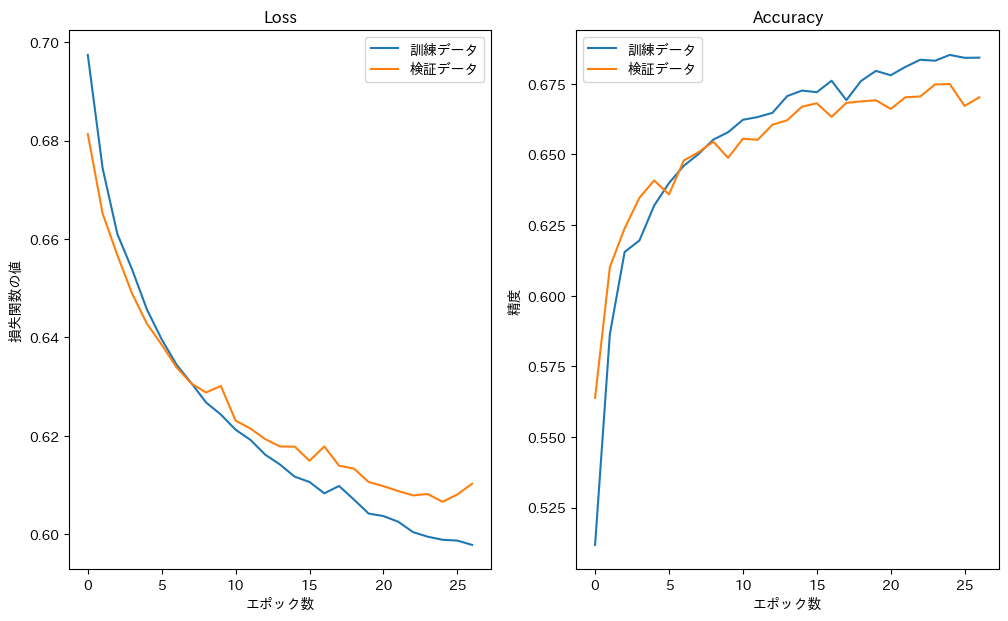

In [10]:
from japanize_matplotlib import japanize_matplotlib
japanize_matplotlib.japanize()

# 結果を可視化
training_loss = history.history["loss"]
val_loss = history.history["val_loss"]

training_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label = "訓練データ")
plt.plot(val_loss, label = "検証データ")
plt.title("Loss")
plt.xlabel("エポック数")
plt.ylabel("損失関数の値")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label = "訓練データ")
plt.plot(val_accuracy, label = "検証データ")
plt.title("Accuracy")
plt.xlabel("エポック数")
plt.ylabel("精度")
plt.legend()
